# Get Our Initial Data

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2





filename=''


data=np.load(filename, allow_pickle=True)

height, width, _ = data[-1].shape



FileNotFoundError: [Errno 2] No such file or directory: ''

In [2]:
import matplotlib.pyplot as plt
import cv2

xcoord=width//3
ycoord=height//2

wide = 20

point0 = [frame[(ycoord - wide // 2):(ycoord + wide // 2), (xcoord - wide // 2):(xcoord + wide // 2)][0] for frame in data]

frame = data[-1]
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(frame)

# Calculate rectangle coordinates
rect_x = xcoord - wide // 2
rect_y = ycoord - wide // 2

# Add rectangle
plt.gca().add_patch(plt.Rectangle((rect_x, rect_y), wide, wide, linewidth=0.5, edgecolor='red', facecolor='none'))
plt.show()

point0 = [np.mean(frame[(ycoord - wide // 2):(ycoord + wide // 2), (xcoord - wide // 2):(xcoord + wide // 2),0]) for frame in data]
point1 = [np.mean(frame[(ycoord - wide // 2):(ycoord + wide // 2), (xcoord - wide // 2):(xcoord + wide // 2),1]) for frame in data]
point2 = [np.mean(frame[(ycoord - wide // 2):(ycoord + wide // 2), (xcoord - wide // 2):(xcoord + wide // 2),2]) for frame in data]

print(len(point0), len(point1), len(point2))
pix_intensity1=point0
pix_intensity2=point1
pix_intensity3=point2

fig, ax = plt.subplots(figsize=(10, 6))
# Plot the pixel intensity values
ax.plot(pix_intensity1, label='Red Channel', color='red')
ax.plot(pix_intensity2, label='Green Channel', color='green')
ax.plot(pix_intensity3, label='Blue Channel', color='blue')

plt.show()




NameError: name 'width' is not defined

In [8]:
import pywt
from scipy.signal import butter, filtfilt, find_peaks

def complex_mag(arr):
    return np.absolute(arr)

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, padlen=14):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, padlen=padlen)
    return y



In [6]:

vid_path='/Users/henryschnieders/Documents/Research/My_work/Data/Videos/100_light_68_64.mp4'
def get_frames(video_path, desired_frames=2000):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Initialize an empty list to store frames
    frames = []

    # Frame processing loop
    frame_count = 0
    while cap.isOpened() and frame_count < desired_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize frame to the desired dimensions
        #frame_resized = cv2.resize(frame, (desired_dimensions, desired_dimensions))

        
        # Add the frame to the list
        frames.append(frame)
        
        frame_count += 1

    # Release the video capture object
    cap.release()

    return fps

fps=get_frames(vid_path)
fps

50.0

324
bpm FFT = 59.03225648719173


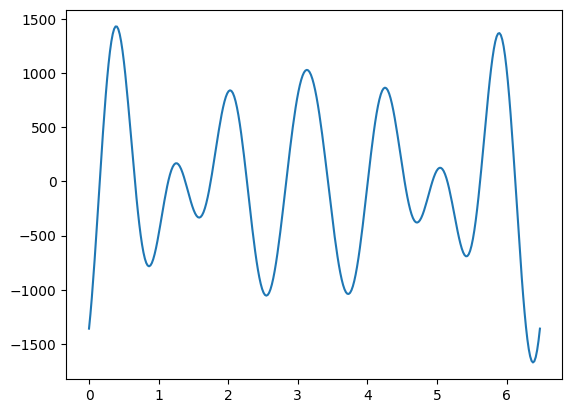

wavelet heart rate is 78.0
butterworth bandpass heart rate is 55.55555555555555
averaged heart rate is 64.19593734758243


In [10]:

# # 1. 读取视频数据

#video_data=Amplitude
# 2. 通过人脸识别确定ROI

#w,h=video_data.shape[1],video_data.shape[2]
#x0,y0,x1,y1=0,0,w,h
pix_intensity=pix_intensity1
# 定义滤波器参数
sampling_rate = fps # 95.2381  # 假设视频帧率为30帧每秒
# 提取心率和呼吸信号的频率范围
# 心率通常在 0.5 - 4 Hz
# 呼吸信号通常在 0.1 - 0.5 Hz
lowcut_heart = 0.5
highcut_heart = 3.0
#lowcut_breath = 0.3
#highcut_breath = 1.0

print(len(pix_intensity))

# 傅里叶变换
N = len(pix_intensity)  # 信号长度
T = 1.0 / sampling_rate  # 采样间隔
coefs = np.fft.fft(pix_intensity)  # 傅里叶变换
freqs = np.fft.fftfreq(N, T) # 获取频率



indices = np.where((np.abs(freqs) >= lowcut_heart) & (np.abs(freqs) <= highcut_heart))

coefsinrange=coefs[indices]
freqsinrange=freqs[indices]

max_indicies=np.argsort(complex_mag(coefsinrange))[-5:]
coefsinrange=coefsinrange[max_indicies]
freqsinrange=freqsinrange[max_indicies]



# print(coefsinrange)
# print("\n")
# print(freqsinrange)
data=np.linspace(0, (1/fps)*len(pix_intensity), len(pix_intensity))
y_dat=[np.real(coefsinrange[i])*np.cos(2*np.pi*freqsinrange[i]*data)+np.imag(coefsinrange[i])*np.sin(2*np.pi*freqsinrange[i]*data) for i in range(len(coefsinrange))]


print(f'bpm FFT = {np.average(np.abs(freqsinrange)*60, weights=complex_mag(coefsinrange))}')
y_dat=np.sum(y_dat, axis=0)
plt.plot(data, y_dat)

plt.show()
# 先进行一次带通滤波

freqsinrange=np.abs(freqsinrange)
roi_mean_ = butter_bandpass_filter(pix_intensity, lowcut_heart, 3, sampling_rate, order=5)
#roi_mean_wavelet = butter_bandpass_filter(roi_mean, 0.1, 9, sampling_rate, order=5)
# print(N, T, len(xf), xf[1:10])


mag=complex_mag(coefs)
indices = np.where((mag >= lowcut_heart) & (mag <= highcut_heart))
# 获取该频段内的频率和幅值
top5_frequencies = freqsinrange
top5_spectrum = coefsinrange
# 计算加权平均
#np.save(f'/Users/henryschnieders/Desktop/Research/My_work/Real_time_recognition/All_face_sections/Approaches/Each_pixel/Data/top5_spectrum_{i}_{j}.npy',top5_spectrum)
FFT_heart_rate = np.average(top5_frequencies, weights=top5_spectrum)

wavelet = 'morl' # 'morl'
scales = np.arange(1, 128)
#coef_, frequencies_ = pywt.cwt(roi_mean_wavelet, scales, wavelet, T)
coef, frequencies = pywt.cwt(roi_mean_, scales, wavelet, T)

# 计算每个尺度的功率谱
average_spectrum = np.mean(np.abs(coef) ** 2, axis=1)
wavelet_peaks, _ = find_peaks(average_spectrum, height=0)
# 输出指定索引对应的频率
# print(wavelet_peaks)
WaveLet_heart_rate = 1.3
if wavelet_peaks is not None:
    index_u = []
    flag_heart = True
    # flag_breath = True
    for index in reversed(wavelet_peaks):
        # print(f"索引 {index}: 频率 {frequencies[index]:.2f} Hz")
        if frequencies[index] > 1.0 and flag_heart:
            flag_heart = False
            WaveLet_heart_rate = frequencies[index]
            index_u.append(index)
            # print(f'WaveLet Heart: {WaveLet_heart_rate * 60:.2f} bpm, {WaveLet_heart_rate:.2f} Hz')

print(f'wavelet heart rate is {WaveLet_heart_rate*60}')

heart_rate_signal = butter_bandpass_filter(roi_mean_, lowcut_heart, highcut_heart, sampling_rate)
peaks_heart, _ = find_peaks(heart_rate_signal, height=0)
Butter_heart_rate = len(peaks_heart) / (len(roi_mean_) / sampling_rate)  # 频率 (bpm)

FFT_heart_rate=np.average(np.abs(freqsinrange)*60, weights=complex_mag(coefsinrange))

heart_rate = ((FFT_heart_rate*(1/60)+WaveLet_heart_rate+Butter_heart_rate)/3)*60

print('butterworth bandpass heart rate is {}'.format(Butter_heart_rate*60))
print(f"averaged heart rate is {heart_rate}")




# Signal Process Using Wavelet-FFT Average

In [9]:

def signal_process_alter(pix_intensity, fps):
    sampling_rate = fps

    lowcut_heart = 0.5
    highcut_heart = 3.0

    N = len(pix_intensity)  # 信号长度
    T = 1.0 / sampling_rate  # 采样间隔
    coefs = np.fft.fft(pix_intensity)  # 傅里叶变换
    freqs = np.fft.fftfreq(N, T) # 获取频率

    indices = np.where((np.abs(freqs) >= lowcut_heart) & (np.abs(freqs) <= highcut_heart))

    coefsinrange=coefs[indices]
    freqsinrange=freqs[indices]
    max_indicies=np.argsort(complex_mag(coefsinrange))[-5:]
    coefsinrange=coefsinrange[max_indicies]
    freqsinrange=freqsinrange[max_indicies]

    wavelet='morl'
    scales=np.arange(1, 128)
    roi_mean_ = butter_bandpass_filter(pix_intensity, lowcut_heart, 3, sampling_rate, order=5)
    coef, frequencies = pywt.cwt(roi_mean_, scales, wavelet, T)
    average_spectrum = np.mean(np.abs(coef) ** 2, axis=1)
    wavelet_peaks, _ = find_peaks(average_spectrum, height=0)
    # 输出指定索引对应的频率
    # print(wavelet_peaks)
    WaveLet_heart_rate = 1.3
    if wavelet_peaks is not None:
        index_u = []
        flag_heart = True
        # flag_breath = True
        for index in reversed(wavelet_peaks):
            # print(f"索引 {index}: 频率 {frequencies[index]:.2f} Hz")
            if frequencies[index] > 1.0 and flag_heart:
                flag_heart = False
                WaveLet_heart_rate = frequencies[index]
                index_u.append(index)

    FFT_heart_rate=np.average(np.abs(freqsinrange), weights=complex_mag(coefsinrange))

    average=(FFT_heart_rate+WaveLet_heart_rate)/2*60
    return average



print(signal_process_alter(pix_intensity1, fps))
print(signal_process_alter(pix_intensity2, fps))
print(signal_process_alter(pix_intensity3, fps))


68.51612824359586
68.36849827235483
74.64513959624429


# Now, Plot the freq spectrum of a pixel up to frame f

In [11]:

#w,h=video_data.shape[1],video_data.shape[2]
#x0,y0,x1,y1=0,0,w,h
pix_intensity=pix_intensity1
# 定义滤波器参数
sampling_rate = fps # 95.2381  # 假设视频帧率为30帧每秒
# 提取心率和呼吸信号的频率范围
# 心率通常在 0.5 - 4 Hz
# 呼吸信号通常在 0.1 - 0.5 Hz
lowcut_heart = 0.5
highcut_heart = 3.0
#lowcut_breath = 0.3
#highcut_breath = 1.0

# 傅里叶变换
N = len(pix_intensity)  # 信号长度
T = 1.0 / sampling_rate  # 采样间隔
coefs = np.fft.fft(pix_intensity)  # 傅里叶变换
freqs = np.fft.fftfreq(N, T) # 获取频率



indices = np.where((np.abs(freqs) >= lowcut_heart) & (np.abs(freqs) <= highcut_heart))

coefsinrange=coefs[indices]
freqsinrange=freqs[indices]

max_indicies=np.argsort(complex_mag(coefsinrange))[-5:]
coefsinrange=coefsinrange[max_indicies]
freqsinrange=freqsinrange[max_indicies]



print(coefsinrange)
print("\n")
print(freqsinrange)
data=np.linspace(0, (1/fps)*len(pix_intensity), len(pix_intensity))
y_dat=[np.real(coefsinrange[i])*np.cos(2*np.pi*freqsinrange[i]*data)+np.imag(coefsinrange[i])*np.sin(2*np.pi*freqsinrange[i]*data) for i in range(len(coefsinrange))]



[-242.96982222+210.42935093j -261.86483956+207.02115136j
 -261.86483956-207.02115136j -295.75716394+170.47883247j
 -295.75716394-170.47883247j]


[ 1.2345679   1.08024691 -1.08024691  0.77160494 -0.77160494]


# ChatGPT Coeff Soln

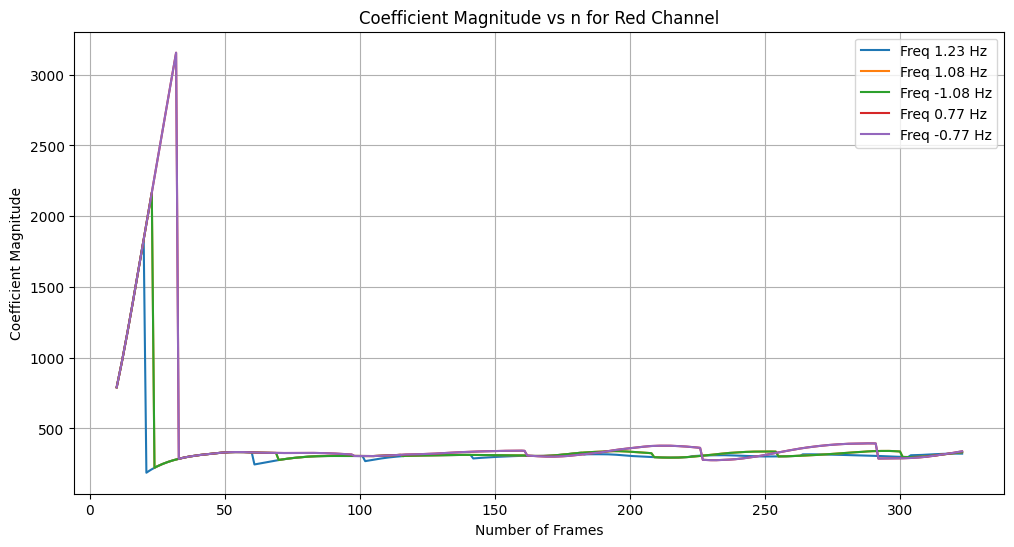

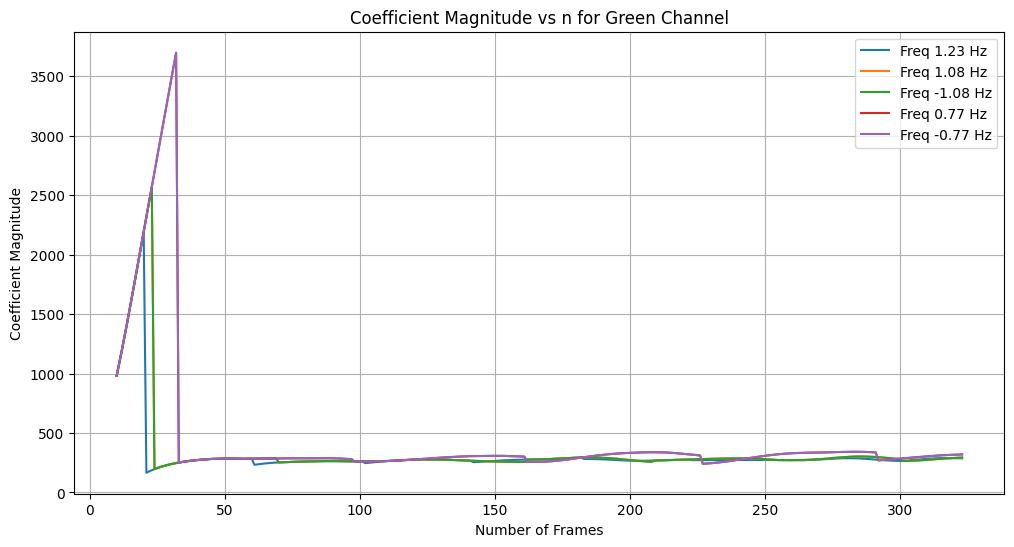

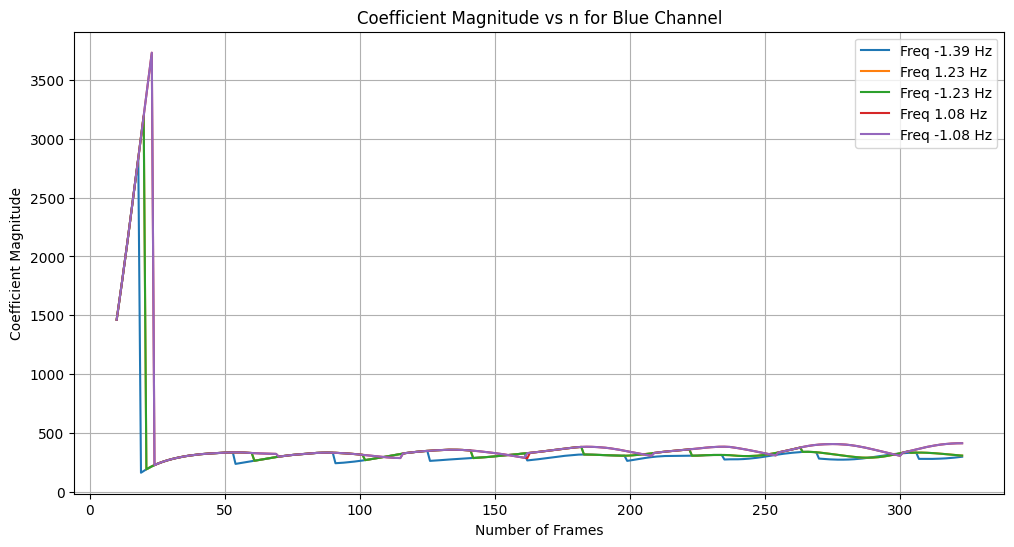

In [12]:
#chatgpt soln



import numpy as np
import matplotlib.pyplot as plt

def complex_mag(x):
    return np.abs(x)

def analyze_pix_intensity(pix_intensity, sampling_rate, lowcut_heart, highcut_heart, label='', start=10):
    N_total = len(pix_intensity)
    T = 1.0 / sampling_rate


    # 1. Compute FFT over the entire data to find the prominent frequencies
    coefs_total = np.fft.fft(pix_intensity)
    freqs_total = np.fft.fftfreq(N_total, T)

    # Select frequency range
    indices = np.where((np.abs(freqs_total) >= lowcut_heart) & (np.abs(freqs_total) <= highcut_heart))
    coefsinrange_total = coefs_total[indices]
    freqsinrange_total = freqs_total[indices]

    # Find top 5 frequencies
    max_indices = np.argsort(complex_mag(coefsinrange_total))[-5:]
    top_coefs = coefsinrange_total[max_indices]
    top_freqs = freqsinrange_total[max_indices]

    # Initialize an array to store coefficients for each n
    coefs_vs_n = np.zeros((len(top_freqs), N_total-start), dtype=complex)

    for n in range(1, N_total-start+1):
        # Get data up to the nth array
        pix_intensity_n = pix_intensity[:(n+start-1)]
        N_n = len(pix_intensity_n)
        T_n = T  # Sampling interval remains the same

        # Compute FFT over data up to the nth array
        coefs_n = np.fft.fft(pix_intensity_n)
        freqs_n = np.fft.fftfreq(N_n, T_n)

        # For each of the top frequencies, get the Fourier coefficients
        for i, f in enumerate(top_freqs):
            # Find the index in freqs_n closest to f
            idx = np.argmin(np.abs(freqs_n - f))
            coefs_vs_n[i, n - 1] = coefs_n[idx]

    
    

    # 2. Plot the coefficient magnitudes with respect to n
    plt.figure(figsize=(12, 6))
    
    
    for i in range(len(top_freqs)):
        plt.plot(range(start, N_total), complex_mag(coefs_vs_n[i, :]), label=f'Freq {top_freqs[i]:.2f} Hz')
        plt.xlabel('Number of Frames')
        plt.ylabel('Coefficient Magnitude')
        plt.title(f'Coefficient Magnitude vs n for {label}')
        plt.legend()
        plt.grid('on')
        plt.savefig('/Users/henryschnieders/Documents/Research/My_work/Current_Summary/Results_10_28/results/'+label+'.png', dpi=600)


# Parameters (adjust as needed)
sampling_rate = fps  # Frame rate of the video
lowcut_heart = 0.5   # Lower bound of heart rate frequency in Hz
highcut_heart = 3.0  # Upper bound of heart rate frequency in Hz

# Assuming pix_intensity1, pix_intensity2, pix_intensity3 are 1D numpy arrays
# Replace these with your actual data
# pix_intensity1 = np.array([...])
# pix_intensity2 = np.array([...])
# pix_intensity3 = np.array([...])

# Analyze and plot for each RGB channel
analyze_pix_intensity(pix_intensity1, sampling_rate, lowcut_heart, highcut_heart, label='Red Channel')
analyze_pix_intensity(pix_intensity2, sampling_rate, lowcut_heart, highcut_heart, label='Green Channel')
analyze_pix_intensity(pix_intensity3, sampling_rate, lowcut_heart, highcut_heart, label='Blue Channel')




# Signal Process Using Just FFT

In [13]:
def signal_process_FFT(pix_intensity, fps):
    sampling_rate = fps

    lowcut_heart = 0.5
    highcut_heart = 3.0

    N = len(pix_intensity)  # 信号长度
    T = 1.0 / sampling_rate  # 采样间隔
    coefs = np.fft.fft(pix_intensity)  # 傅里叶变换
    freqs = np.fft.fftfreq(N, T) # 获取频率

    indices = np.where((np.abs(freqs) >= lowcut_heart) & (np.abs(freqs) <= highcut_heart))

    coefsinrange=coefs[indices]
    freqsinrange=freqs[indices]
    max_indicies=np.argsort(complex_mag(coefsinrange))[-5:]
    coefsinrange=coefsinrange[max_indicies]
    freqsinrange=freqsinrange[max_indicies]

    FFT_heart_rate=np.average(np.abs(freqsinrange), weights=complex_mag(coefsinrange))

    return FFT_heart_rate*60


# Averaged Coefficients

Red Channel freq is 100.0912685240346
Green Channel freq is 70.42341653687456
Blue Channel freq is 51.17423346821029


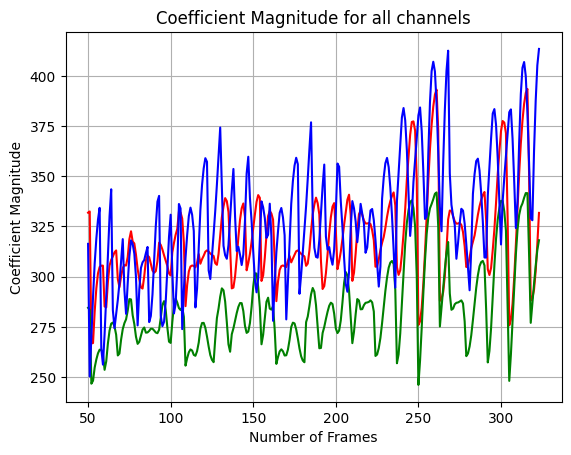

In [14]:
#chatgpt soln



import numpy as np
import matplotlib.pyplot as plt

def complex_mag(x):
    return np.absolute(x)

def analyze_pix_intensity(pix_intensity, sampling_rate, lowcut_heart, highcut_heart, color, label='', start=50):
    N_total = len(pix_intensity)
    T = 1.0 / sampling_rate


    # 1. Compute FFT over the entire data to find the prominent frequencies
    coefs_total = np.fft.fft(pix_intensity)
    freqs_total = np.fft.fftfreq(N_total, T)

    # Select frequency range
    indices = np.where((np.abs(freqs_total) >= lowcut_heart) & (np.abs(freqs_total) <= highcut_heart))
    coefsinrange_total = coefs_total[indices]
    freqsinrange_total = freqs_total[indices]

    # Find top 5 frequencies
    max_indices = np.argsort(complex_mag(coefsinrange_total))[-5:]
    top_coefs = coefsinrange_total[max_indices]
    top_freqs = freqsinrange_total[max_indices]

    # Initialize an array to store coefficients for each n
    coefs_vs_n = np.zeros((len(top_freqs), N_total-start), dtype=complex)

    for n in range(1, N_total-start+1):
        # Get data up to the nth array
        pix_intensity_n = pix_intensity[:(n+start-1)]
        N_n = len(pix_intensity_n)
        T_n = T  # Sampling interval remains the same

        # Compute FFT over data up to the nth array
        coefs_n = np.fft.fft(pix_intensity_n)
        freqs_n = np.fft.fftfreq(N_n, T_n)

        # For each of the top frequencies, get the Fourier coefficients
        for i, f in enumerate(top_freqs):
            # Find the index in freqs_n closest to f
            idx = np.argmin(np.abs(freqs_n - f))
            coefs_vs_n[i, n - 1] = coefs_n[idx]

    # 2. Plot the coefficient magnitudes with respect to n


    
    ydata=[np.mean(complex_mag(freqs)) for freqs in coefs_vs_n.reshape((N_total-start, len(top_freqs)))]
    plt.plot(range(start, N_total), ydata, label=f'Averaged top 5 frequencies', color=color)
    
    print(f'{label} freq is {signal_process_FFT(ydata, fps)}')
    
plt.ion()



# Parameters (adjust as needed)
sampling_rate = fps  # Frame rate of the video
lowcut_heart = 0.5   # Lower bound of heart rate frequency in Hz
highcut_heart = 3.0  # Upper bound of heart rate frequency in Hz

# Assuming 
# , pix_intensity2, pix_intensity3 are 1D numpy arrays
# Replace these with your actual data
# pix_intensity1 = np.array([...])
# pix_intensity2 = np.array([...])
# pix_intensity3 = np.array([...])

# Analyze and plot for each RGB channel
colors=['red', 'green', 'blue']
analyze_pix_intensity(pix_intensity1, sampling_rate, lowcut_heart, highcut_heart, label='Red Channel', color=colors[0])
analyze_pix_intensity(pix_intensity2, sampling_rate, lowcut_heart, highcut_heart, label='Green Channel', color=colors[1])
analyze_pix_intensity(pix_intensity3, sampling_rate, lowcut_heart, highcut_heart, label='Blue Channel', color=colors[2])

plt.xlabel('Number of Frames')
plt.ylabel('Coefficient Magnitude')
plt.title(f'Coefficient Magnitude for all channels')

plt.grid('on')
plt.savefig('/Users/henryschnieders/Documents/Research/My_work/Current_Summary/Results_10_28/results/'+'all'+ 'averaged.png', dpi=600)



# All together

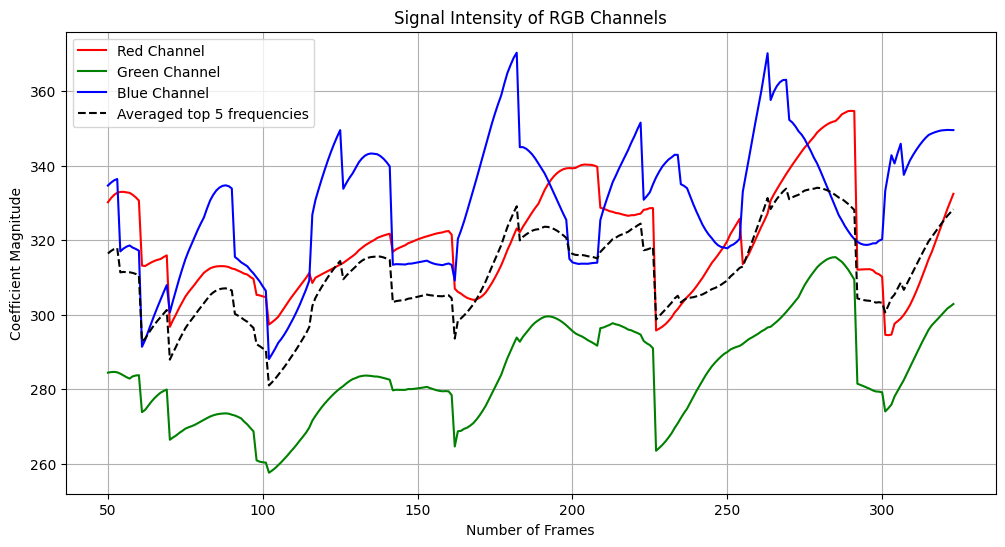

In [17]:
import numpy as np
import matplotlib.pyplot as plt





def complex_mag(x):
    return np.absolute(x)

def analyze_pix_intensity(pix_intensity, sampling_rate, lowcut_heart, highcut_heart, start=50):
    N_total = len(pix_intensity)
    T = 1.0 / sampling_rate

    # 1. Compute FFT over the entire data to find the prominent frequencies
    coefs_total = np.fft.fft(pix_intensity)
    freqs_total = np.fft.fftfreq(N_total, T)

    # Select frequency range
    indices = np.where((np.abs(freqs_total) >= lowcut_heart) & (np.abs(freqs_total) <= highcut_heart))
    coefsinrange_total = coefs_total[indices]
    freqsinrange_total = freqs_total[indices]

    # Find top 5 frequencies
    max_indices = np.argsort(complex_mag(coefsinrange_total))[-5:]
    top_coefs = coefsinrange_total[max_indices]
    top_freqs = freqsinrange_total[max_indices]

    # Initialize an array to store coefficients for each n
    coefs_vs_n = np.zeros((len(top_freqs), N_total - start), dtype=complex)

    for n in range(1, N_total - start + 1):
        # Get data up to the (n + start - 1)th sample
        pix_intensity_n = pix_intensity[:(n + start - 1)]
        N_n = len(pix_intensity_n)
        T_n = T  # Sampling interval remains the same

        # Compute FFT over data up to the nth array
        coefs_n = np.fft.fft(pix_intensity_n)
        freqs_n = np.fft.fftfreq(N_n, T_n)

        # For each of the top frequencies, get the Fourier coefficients
        for i, f in enumerate(top_freqs):
            # Find the index in freqs_n closest to f
            idx = np.argmin(np.abs(freqs_n - f))
            coefs_vs_n[i, n - 1] = coefs_n[idx]

    # 2. Compute the mean magnitude of the coefficients for each n
    ydata = [np.mean(complex_mag(coefs_vs_n[:, n])) for n in range(N_total - start)]

    return ydata

# Parameters (adjust as needed)
sampling_rate = fps  # Frame rate of the video
lowcut_heart = 0.5   # Lower bound of heart rate frequency in Hz
highcut_heart = 3.0  # Upper bound of heart rate frequency in Hz
start = 50

# Assuming pix_intensity1, pix_intensity2, pix_intensity3 are defined
# as 1D numpy arrays representing intensity over time for each color channel

ydatas = []
liss = [pix_intensity1, pix_intensity2, pix_intensity3]
for j in range(3):
    ydata = analyze_pix_intensity(liss[j], sampling_rate, lowcut_heart, highcut_heart, start=start)
    ydatas.append(ydata)



plt.figure(figsize=(12, 6))

labels = ['Red Channel', 'Green Channel', 'Blue Channel']
colors = ['r', 'g', 'b']

N_total = len(pix_intensity1)
x_values = range(start, N_total)

for j in range(3):
    plt.plot(x_values, ydatas[j], label=labels[j], color=colors[j])

ydat_sum = np.mean(ydatas, axis=0)

plt.plot(x_values, ydat_sum, label='Averaged top 5 frequencies', color='black', linestyle='--')

plt.xlabel('Number of Frames')
plt.ylabel('Coefficient Magnitude')
plt.title('Signal Intensity of RGB Channels')
plt.legend()
plt.grid(True)
plt.savefig('/Users/henryschnieders/downloads/averaged.png', dpi=600)
plt.show()


In [16]:

import matplotlib.pyplot as plt
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt


filename='/Users/henryschnieders/Documents/Research/My_work/Data/100_light_94_94_padding_color_mp4.npy'
vid_path='/Users/henryschnieders/Documents/Research/My_work/Current_Summary/Results_10_21/Videos/mp4/100_light_94_94.mp4'

def get_frames(video_path, desired_frames=2000):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Initialize an empty list to store frames
    frames = []

    # Frame processing loop
    frame_count = 0
    while cap.isOpened() and frame_count < desired_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize frame to the desired dimensions
        #frame_resized = cv2.resize(frame, (desired_dimensions, desired_dimensions))

        
        # Add the frame to the list
        frames.append(frame)
        
        frame_count += 1

    # Release the video capture object
    cap.release()

    return fps

fps=get_frames(vid_path)


import matplotlib.pyplot as plt
import cv2

xcoord=width//3
ycoord=height//2

wide = 20

point0 = [frame[(ycoord - wide // 2):(ycoord + wide // 2), (xcoord - wide // 2):(xcoord + wide // 2)][0] for frame in data]

frame = data[-1]
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(frame)

# Calculate rectangle coordinates
rect_x = xcoord - wide // 2
rect_y = ycoord - wide // 2

# Add rectangle
plt.gca().add_patch(plt.Rectangle((rect_x, rect_y), wide, wide, linewidth=0.5, edgecolor='red', facecolor='none'))
plt.show()

point0 = [np.mean(frame[(ycoord - wide // 2):(ycoord + wide // 2), (xcoord - wide // 2):(xcoord + wide // 2),0]) for frame in data]
point1 = [np.mean(frame[(ycoord - wide // 2):(ycoord + wide // 2), (xcoord - wide // 2):(xcoord + wide // 2),1]) for frame in data]
point2 = [np.mean(frame[(ycoord - wide // 2):(ycoord + wide // 2), (xcoord - wide // 2):(xcoord + wide // 2),2]) for frame in data]

print(len(point0), len(point1), len(point2))
pix_intensity1=point0
pix_intensity2=point1
pix_intensity3=point2


data=np.load(filename, allow_pickle=True)

height, width, _ = data[-1].shape









def complex_mag(x):
    return np.absolute(x)

def analyze_pix_intensity(pix_intensity, sampling_rate, lowcut_heart, highcut_heart, start=50):
    N_total = len(pix_intensity)
    T = 1.0 / sampling_rate

    # 1. Compute FFT over the entire data to find the prominent frequencies
    coefs_total = np.fft.fft(pix_intensity)
    freqs_total = np.fft.fftfreq(N_total, T)

    # Select frequency range
    indices = np.where((np.abs(freqs_total) >= lowcut_heart) & (np.abs(freqs_total) <= highcut_heart))
    coefsinrange_total = coefs_total[indices]
    freqsinrange_total = freqs_total[indices]

    # Find top 5 frequencies
    max_indices = np.argsort(complex_mag(coefsinrange_total))[-5:]
    top_coefs = coefsinrange_total[max_indices]
    top_freqs = freqsinrange_total[max_indices]

    # Initialize an array to store coefficients for each n
    coefs_vs_n = np.zeros((len(top_freqs), N_total - start), dtype=complex)

    for n in range(1, N_total - start + 1):
        # Get data up to the (n + start - 1)th sample
        pix_intensity_n = pix_intensity[:(n + start - 1)]
        N_n = len(pix_intensity_n)
        T_n = T  # Sampling interval remains the same

        # Compute FFT over data up to the nth array
        coefs_n = np.fft.fft(pix_intensity_n)
        freqs_n = np.fft.fftfreq(N_n, T_n)

        # For each of the top frequencies, get the Fourier coefficients
        for i, f in enumerate(top_freqs):
            # Find the index in freqs_n closest to f
            idx = np.argmin(np.abs(freqs_n - f))
            coefs_vs_n[i, n - 1] = coefs_n[idx]

    # 2. Compute the mean magnitude of the coefficients for each n
    ydata = [np.mean(complex_mag(coefs_vs_n[:, n])) for n in range(N_total - start)]

    return ydata

# Parameters (adjust as needed)
sampling_rate = fps  # Frame rate of the video
lowcut_heart = 0.5   # Lower bound of heart rate frequency in Hz
highcut_heart = 3.0  # Upper bound of heart rate frequency in Hz
start = 50

# Assuming pix_intensity1, pix_intensity2, pix_intensity3 are defined
# as 1D numpy arrays representing intensity over time for each color channel

ydatas = []
liss = [pix_intensity1, pix_intensity2, pix_intensity3]
for j in range(3):
    ydata = analyze_pix_intensity(liss[j], sampling_rate, lowcut_heart, highcut_heart, start=start)
    ydatas.append(ydata)

plt.figure(figsize=(12, 6))

labels = ['Red Channel', 'Green Channel', 'Blue Channel']
colors = ['r', 'g', 'b']

N_total = len(pix_intensity1)
x_values = range(start, N_total)

for j in range(3):
    plt.plot(x_values, ydatas[j], label=labels[j], color=colors[j])

plt.xlabel('Number of Frames')
plt.ylabel('Coefficient Magnitude')
plt.title('Signal Intensity of RGB Channels')
plt.legend()
plt.grid(True)
plt.savefig('averaged.png', dpi=600)
plt.show()





IndexError: invalid index to scalar variable.

Processing pix_intensity1
Target frequencies (Hz): [0.55397727 0.54166667 0.5298913  0.51861702 0.5078125 ]


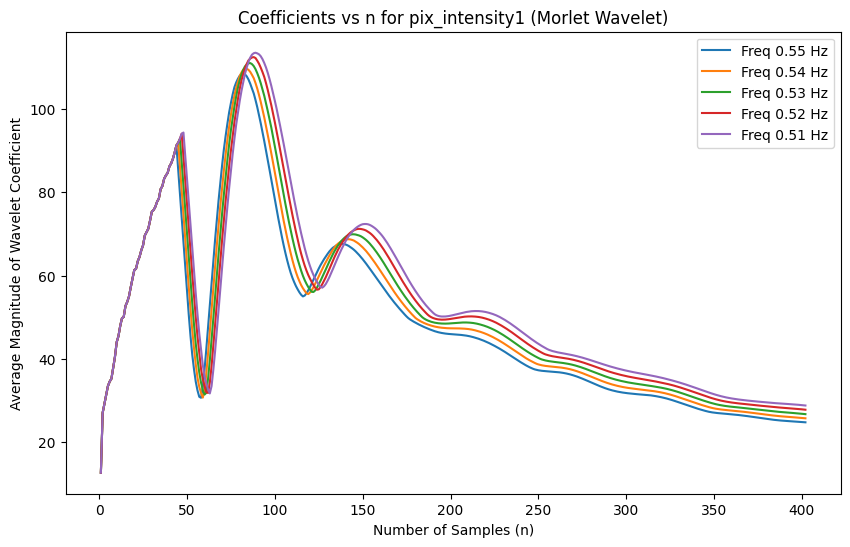

Processing pix_intensity2
Target frequencies (Hz): [0.55397727 0.54166667 0.5298913  0.51861702 0.5078125 ]


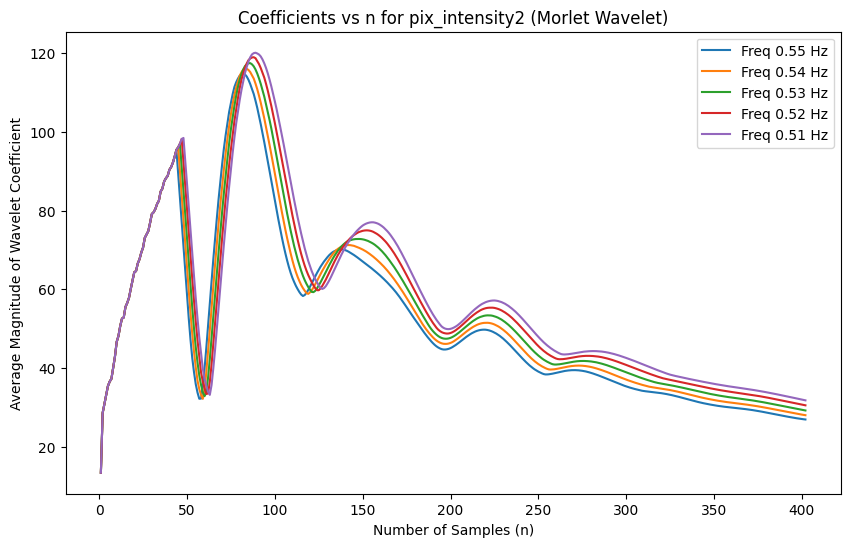

Processing pix_intensity3
Target frequencies (Hz): [0.55397727 0.54166667 0.5298913  0.51861702 0.5078125 ]


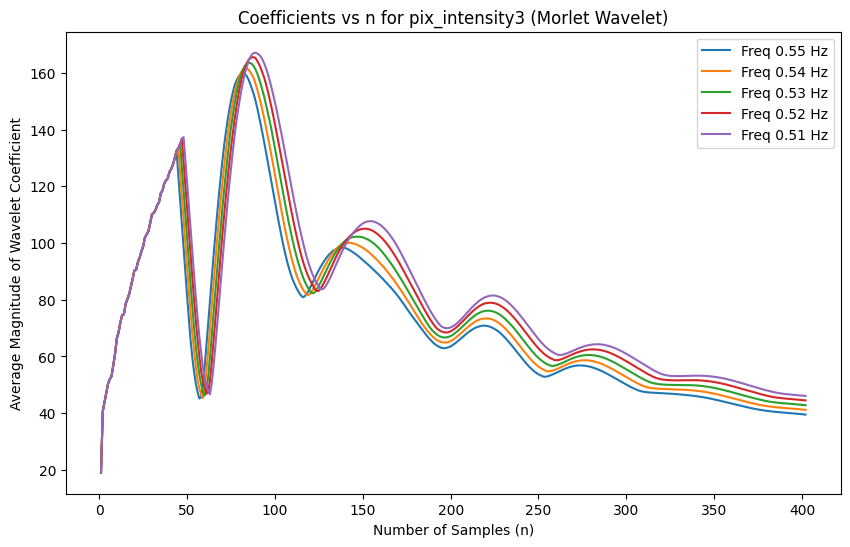

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.signal import find_peaks

# Assuming fps, lowcut_heart, and highcut_heart are defined
fps = 30.0  # Example value, replace with actual fps
sampling_rate = fps
dt = 1.0 / sampling_rate  # Sampling interval
lowcut_heart = 0.5
highcut_heart = 3.0

# Assuming pix_intensity1, pix_intensity2, pix_intensity3 are defined
# They should be 1D numpy arrays representing pixel intensity over time

pix_intensity_list = [pix_intensity1, pix_intensity2, pix_intensity3]

for idx, pix_intensity in enumerate(pix_intensity_list, start=1):
    print(f"Processing pix_intensity{idx}")

    N_total = len(pix_intensity)
    time = np.arange(N_total) * dt

    # Define scales for the wavelet transform
    scales = np.arange(1, N_total + 1)

    # 1. Compute the wavelet transform over the entire data to find prominent frequencies
    coef_full, freqs_full = pywt.cwt(pix_intensity, scales, 'morl', dt)

    # Compute the average spectrum (mean power across time for each scale)
    power_full = np.mean(np.abs(coef_full) ** 2, axis=1)

    # Convert scales to frequencies
    frequencies_full = pywt.scale2frequency('morl', scales) / dt

    # Filter frequencies within the heart rate range
    indices = np.where((frequencies_full >= lowcut_heart) & (frequencies_full <= highcut_heart))[0]
    frequencies_in_range = frequencies_full[indices]
    power_in_range = power_full[indices]

    # Find the top 5 frequencies
    top_indices = np.argsort(power_in_range)[-5:]
    target_frequencies = frequencies_in_range[top_indices]
    target_scales = scales[indices][top_indices]

    print("Target frequencies (Hz):", target_frequencies)

    # Prepare lists to store the magnitudes of the coefficients over n
    n_values = []
    coef_magnitudes = [[] for _ in range(len(target_scales))]

    # 2. Iterate over n from 1 to N_total
    for n in range(1, N_total + 1):
        data_n = pix_intensity[:n]
        time_n = time[:n]
        scales_n = np.arange(1, n + 1)

        # Compute the wavelet transform for this subset of data
        coef_n, freqs_n = pywt.cwt(data_n, scales_n, 'morl', dt)

        # Convert scales to frequencies
        frequencies_n = pywt.scale2frequency('morl', scales_n) / dt

        # For each target scale, find the closest scale in the subset
        for i, scale_target in enumerate(target_scales):
            idx_scale = (np.abs(scales_n - scale_target)).argmin()
            coef_at_scale = coef_n[idx_scale, :]
            magnitude = np.mean(np.abs(coef_at_scale))
            coef_magnitudes[i].append(magnitude)

        n_values.append(n)

    # 3. Plot the magnitude of the coefficients versus n
    plt.figure(figsize=(10, 6))
    for i in range(len(target_frequencies)):
        plt.plot(n_values, coef_magnitudes[i], label=f'Freq {target_frequencies[i]:.2f} Hz')

    plt.xlabel('Number of Samples (n)')
    plt.ylabel('Average Magnitude of Wavelet Coefficient')
    plt.title(f'Coefficients vs n for pix_intensity{idx} (Morlet Wavelet)')
    plt.legend()
    plt.show()


# Try Tracking Other frequencies

[26.5336827 26.5336827]
40921.80750000001
[ 1.61691542 -1.61691542]


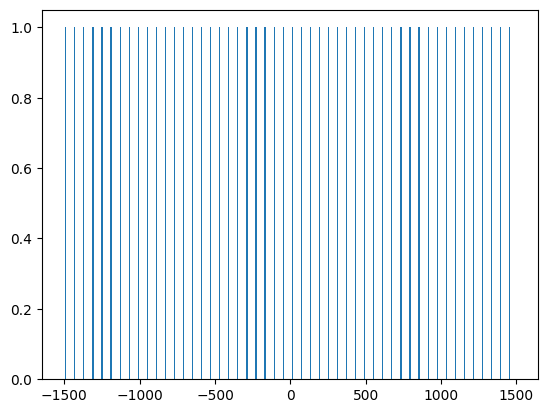

In [8]:


sampling_rate = fps

lowcut_heart = 0.5
highcut_heart = 3.0

N = len(pix_intensity1)   
T = 1.0 / sampling_rate  
coefs = np.fft.fft(pix_intensity1)   
freqs = np.fft.fftfreq(N, T)  

indices = np.where((np.abs(freqs) >= lowcut_heart) & (np.abs(freqs) <= highcut_heart)) 

coefsinrange=coefs[indices] 
freqsinrange=freqs[indices]

max_indicies=np.argsort(complex_mag(coefsinrange))[-5:] 

FFT_heart_rate=np.average(np.abs(freqsinrange), weights=complex_mag(coefsinrange)) 
 
y=np.ones(len(coefs))

plt.bar(freqs*60, y, width=1) 

tol=0.05
indicess = np.where((np.abs(freqs) >= 1.57-tol) & (np.abs(freqs) <= 1.57+tol)) 
print(complex_mag(coefs[indicess]))
print(np.max(complex_mag(coefs)))
print(freqs[indicess])


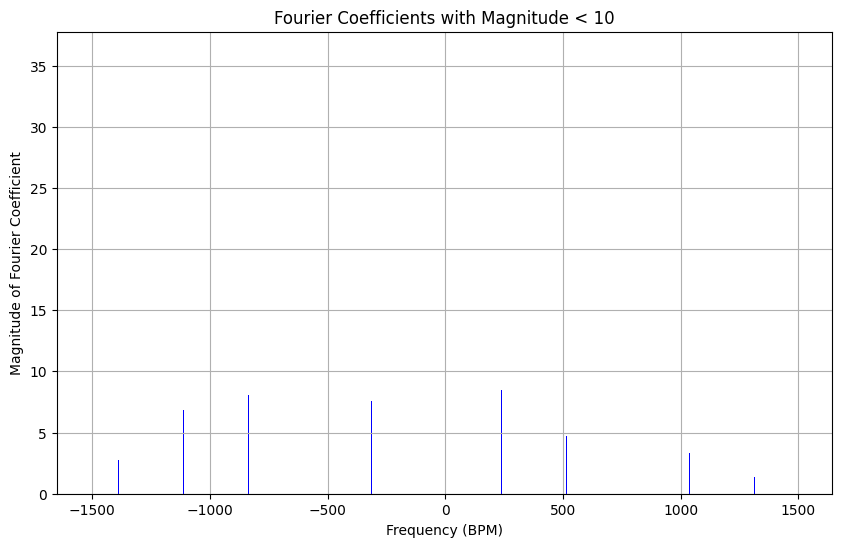

In [9]:
# Assuming 'coefs' and 'freqs' are already computed from your FFT
# And 'complex_mag' is defined to compute the magnitude of complex numbers

# Compute the magnitude of the Fourier coefficients
mag_coefs = complex_mag(coefs)

# Find indices where the magnitude is less than 10
indices = np.where(mag_coefs < 40)

# Extract the corresponding frequencies and magnitudes
freqs_sub = freqs[indices]
mag_coefs_sub = mag_coefs[indices]

# Convert frequencies to BPM (beats per minute) if desired
freqs_sub_bpm = freqs_sub * 60

# Plot the frequencies where magnitude < 10
plt.figure(figsize=(10, 6))
plt.bar(freqs_sub_bpm, mag_coefs_sub, width=0.1, color='blue')
plt.xlabel('Frequency (BPM)')
plt.ylabel('Magnitude of Fourier Coefficient')
plt.title('Fourier Coefficients with Magnitude < 10')
plt.grid(True)
plt.show()


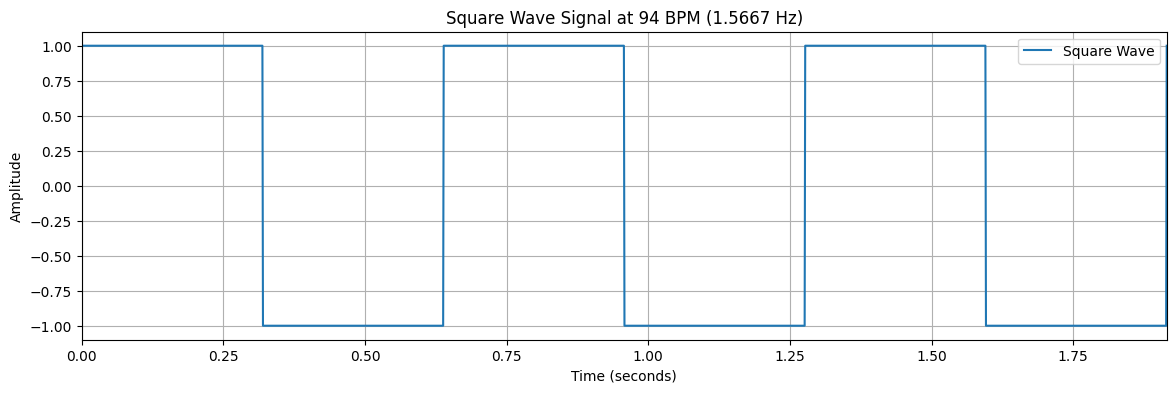

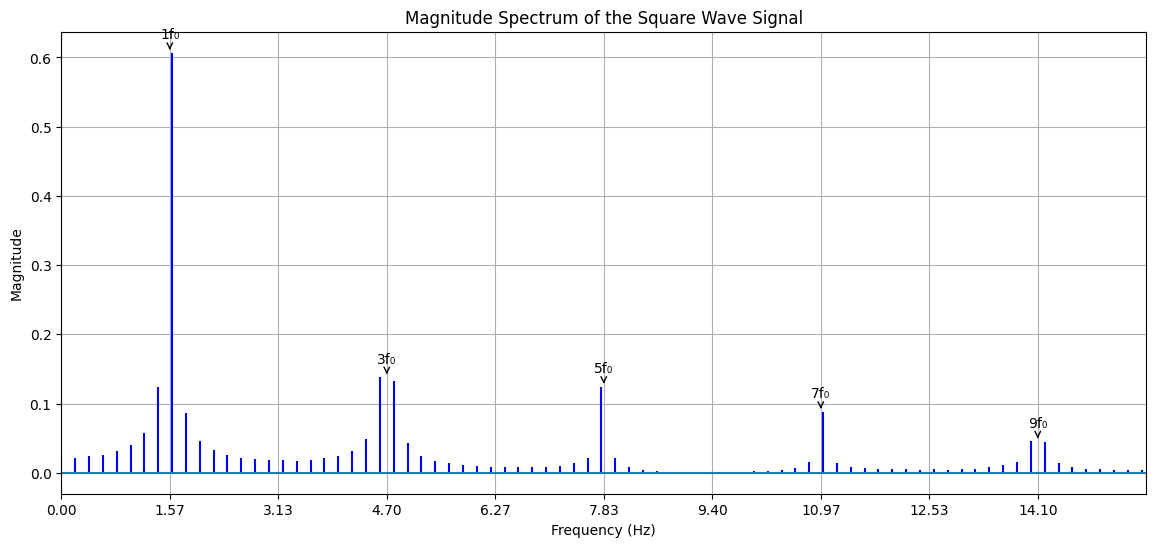

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import square

# Define parameters
bpm = 94  # Beats per minute
f0 = bpm / 60.0  # Fundamental frequency in Hz
T = 5  # Total time duration in seconds
sampling_rate = 1000  # Samples per second
N = int(T * sampling_rate)  # Total number of samples

# Time vector
t = np.linspace(0, T, N, endpoint=False)

# Generate square wave signal
signal = square(2 * np.pi * f0 * t)

# Compute Fourier Transform
fft_signal = np.fft.fft(signal)
freqs = np.fft.fftfreq(N, 1 / sampling_rate)

# Only keep the positive frequencies
positive_freqs = freqs[:N // 2]
fft_magnitude = np.abs(fft_signal[:N // 2]) / N  # Normalize magnitude

# Plot the time-domain signal
plt.figure(figsize=(14, 4))
plt.plot(t, signal, label='Square Wave')
plt.title(f'Square Wave Signal at {bpm} BPM ({f0:.4f} Hz)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim(0, 3 / f0)  # Display a few periods
plt.grid(True)
plt.legend()
plt.show()

# Plot the magnitude spectrum
plt.figure(figsize=(14, 6))
plt.stem(positive_freqs, fft_magnitude, 'b', markerfmt=" ", basefmt="-")  # Removed 'use_line_collection'
plt.title('Magnitude Spectrum of the Square Wave Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 10 * f0)  # Show up to the 10th harmonic
plt.xticks(np.arange(0, 10 * f0, f0))
plt.grid(True)

# Annotate the fundamental frequency and harmonics
for n in range(1, 11, 2):  # Only odd harmonics for a square wave
    freq = n * f0
    idx = np.argmin(np.abs(positive_freqs - freq))
    plt.annotate(f'{n}f₀', xy=(freq, fft_magnitude[idx]), xytext=(freq, fft_magnitude[idx] + 0.02),
                 arrowprops=dict(facecolor='red', arrowstyle='->'), ha='center')
plt.show()


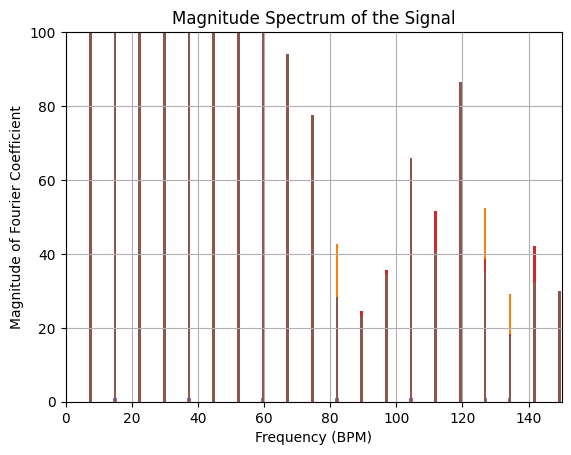

In [ ]:
sampling_rate = fps

lowcut_heart = 0.5
highcut_heart = 3.0

N = len(pix_intensity1)   
T = 1.0 / sampling_rate  
coefs = np.fft.fft(pix_intensity1)   
freqs = np.fft.fftfreq(N, T)  

indices = np.where((np.abs(freqs) >= lowcut_heart) & (np.abs(freqs) <= highcut_heart)) 

coefsinrange=coefs[indices] 
freqsinrange=freqs[indices]

max_indicies=np.argsort(complex_mag(coefsinrange))[-5:] 

FFT_heart_rate=np.average(np.abs(freqsinrange), weights=complex_mag(coefsinrange)) 
 
y=np.ones(len(coefs))

plt.bar(freqs*60, y, width=1) 

tol=0.05
indicess = np.where((np.abs(freqs) >= 1.57-tol) & (np.abs(freqs) <= 1.57+tol)) 


# Compute the magnitude of the Fourier coefficients
mag_coefs = complex_mag(coefs)

# Convert frequencies to BPM (beats per minute)
freqs_bpm = freqs * 60

# Select positive frequencies only
positive_freq_indices = np.where(freqs >= 0)
freqs_pos_bpm = freqs_bpm[positive_freq_indices]
mag_coefs_pos = mag_coefs[positive_freq_indices]

# Plot the full magnitude spectrum
plt.bar(freqs_pos_bpm, mag_coefs_pos)





sampling_rate = fps

lowcut_heart = 0.5
highcut_heart = 3.0

N = len(pix_intensity2)   
T = 1.0 / sampling_rate  
coefs = np.fft.fft(pix_intensity2)   
freqs = np.fft.fftfreq(N, T)  

indices = np.where((np.abs(freqs) >= lowcut_heart) & (np.abs(freqs) <= highcut_heart)) 

coefsinrange=coefs[indices] 
freqsinrange=freqs[indices]

max_indicies=np.argsort(complex_mag(coefsinrange))[-5:] 

FFT_heart_rate=np.average(np.abs(freqsinrange), weights=complex_mag(coefsinrange)) 
 
y=np.ones(len(coefs))

plt.bar(freqs*60, y, width=1) 

tol=0.05
indicess = np.where((np.abs(freqs) >= 1.57-tol) & (np.abs(freqs) <= 1.57+tol)) 


# Compute the magnitude of the Fourier coefficients
mag_coefs = complex_mag(coefs)

# Convert frequencies to BPM (beats per minute)
freqs_bpm = freqs * 60

# Select positive frequencies only
positive_freq_indices = np.where(freqs >= 0)
freqs_pos_bpm = freqs_bpm[positive_freq_indices]
mag_coefs_pos = mag_coefs[positive_freq_indices]

# Plot the full magnitude spectrum
plt.bar(freqs_pos_bpm, mag_coefs_pos)








sampling_rate = fps

lowcut_heart = 0.5
highcut_heart = 3.0

N = len(pix_intensity3)   
T = 1.0 / sampling_rate  
coefs = np.fft.fft(pix_intensity3)   
freqs = np.fft.fftfreq(N, T)  

indices = np.where((np.abs(freqs) >= lowcut_heart) & (np.abs(freqs) <= highcut_heart)) 

coefsinrange=coefs[indices] 
freqsinrange=freqs[indices]

max_indicies=np.argsort(complex_mag(coefsinrange))[-5:] 

FFT_heart_rate=np.average(np.abs(freqsinrange), weights=complex_mag(coefsinrange)) 
 
y=np.ones(len(coefs))

plt.bar(freqs*60, y, width=1) 

tol=0.05
indicess = np.where((np.abs(freqs) >= 1.57-tol) & (np.abs(freqs) <= 1.57+tol)) 


# Compute the magnitude of the Fourier coefficients
mag_coefs = complex_mag(coefs)

# Convert frequencies to BPM (beats per minute)
freqs_bpm = freqs * 60

# Select positive frequencies only
positive_freq_indices = np.where(freqs >= 0)
freqs_pos_bpm = freqs_bpm[positive_freq_indices]
mag_coefs_pos = mag_coefs[positive_freq_indices]

# Plot the full magnitude spectrum
plt.bar(freqs_pos_bpm, mag_coefs_pos)
plt.xlabel('Frequency (BPM)')
plt.ylabel('Magnitude of Fourier Coefficient')
plt.title('Magnitude Spectrum of the Signal')
plt.grid(True)
plt.xlim(0, 150)  # Adjust the range as needed
plt.ylim(0, 100)  # Adjust the range as needed

plt.savefig('/Users/henryschnieders/desktop/averaged.png', dpi=600)




#bandpass filter between 1 and 2 hz
#wavelet transform

#freq is 94

[35.74329466 35.74329466]
43143.85999999999
[ 1.61691542 -1.61691542]


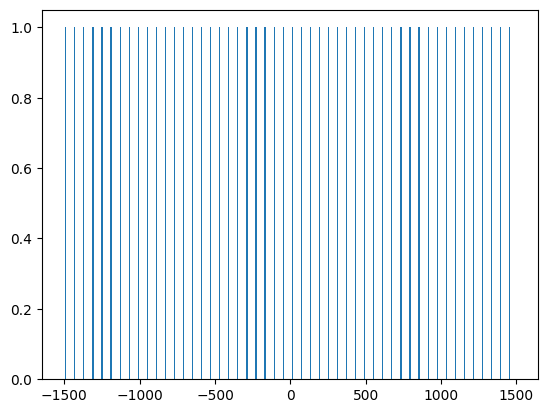

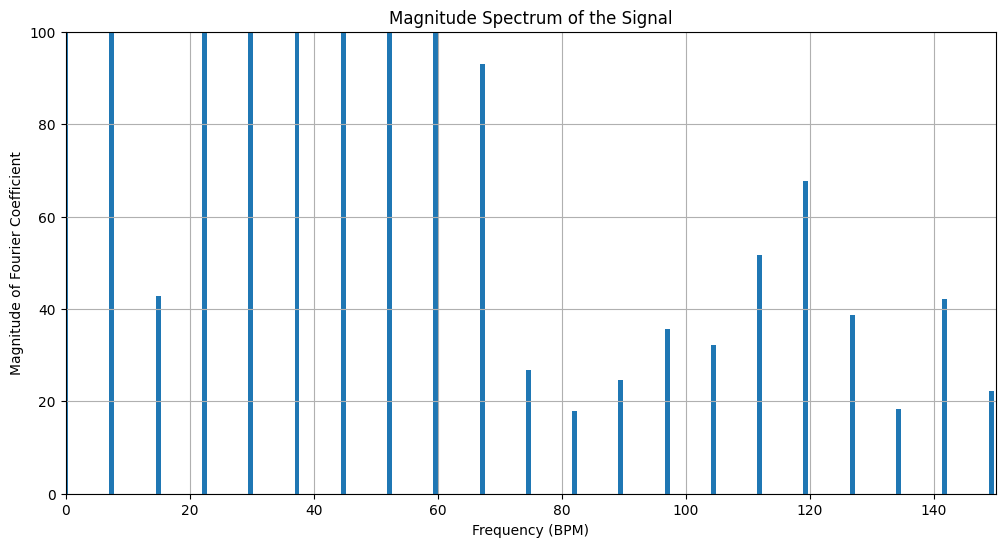

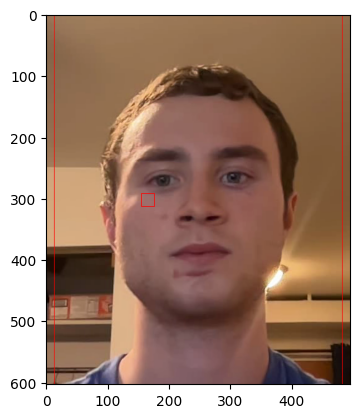

390 390 390
[17.53278761 17.53278761]
41861.5075
[ 1.53846154 -1.53846154]


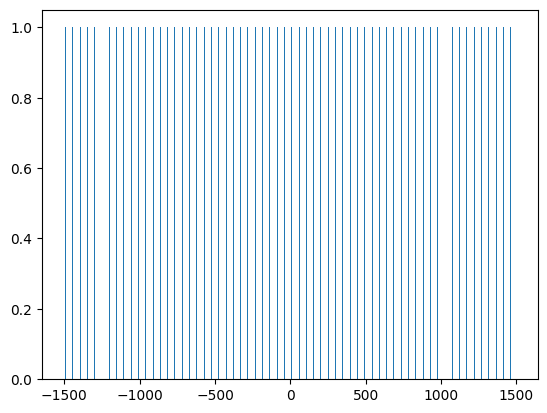

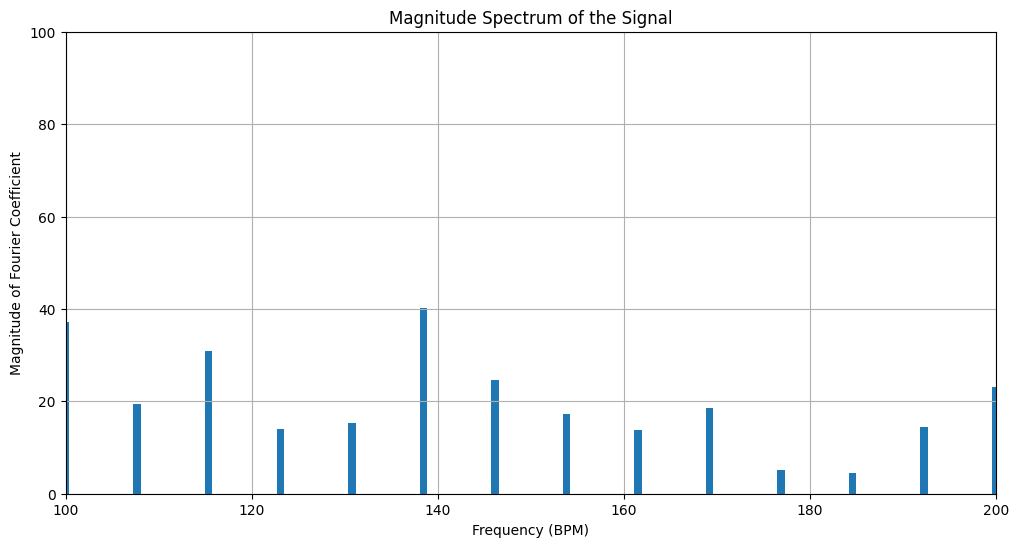

In [49]:

filename='/Users/henryschnieders/Documents/Research/My_work/Data/100_light_135_125_padding_color_mp4.npy'


data=np.load(filename, allow_pickle=True)

height, width, _ = data[-1].shape


xcoord=width//3
ycoord=height//2

wide = 20

point0 = [frame[(ycoord - wide // 2):(ycoord + wide // 2), (xcoord - wide // 2):(xcoord + wide // 2)][0] for frame in data]

frame = data[-1]
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(frame)

# Calculate rectangle coordinates
rect_x = xcoord - wide // 2
rect_y = ycoord - wide // 2

# Add rectangle
plt.gca().add_patch(plt.Rectangle((rect_x, rect_y), wide, wide, linewidth=0.5, edgecolor='red', facecolor='none'))
plt.show()

point0 = [np.mean(frame[(ycoord - wide // 2):(ycoord + wide // 2), (xcoord - wide // 2):(xcoord + wide // 2),0]) for frame in data]
point1 = [np.mean(frame[(ycoord - wide // 2):(ycoord + wide // 2), (xcoord - wide // 2):(xcoord + wide // 2),1]) for frame in data]
point2 = [np.mean(frame[(ycoord - wide // 2):(ycoord + wide // 2), (xcoord - wide // 2):(xcoord + wide // 2),2]) for frame in data]

print(len(point0), len(point1), len(point2))
pix_intensity1=point0
pix_intensity2=point1
pix_intensity3=point2



sampling_rate = fps

lowcut_heart = 0.5
highcut_heart = 3.0

N = len(pix_intensity1)   
T = 1.0 / sampling_rate  
coefs = np.fft.fft(pix_intensity1)   
freqs = np.fft.fftfreq(N, T)  

indices = np.where((np.abs(freqs) >= lowcut_heart) & (np.abs(freqs) <= highcut_heart)) 

coefsinrange=coefs[indices] 
freqsinrange=freqs[indices]

max_indicies=np.argsort(complex_mag(coefsinrange))[-5:] 

FFT_heart_rate=np.average(np.abs(freqsinrange), weights=complex_mag(coefsinrange)) 
 
y=np.ones(len(coefs))

plt.bar(freqs*60, y, width=1) 

tol=0.05
indicess = np.where((np.abs(freqs) >= 1.57-tol) & (np.abs(freqs) <= 1.57+tol)) 
print(complex_mag(coefs[indicess]))
print(np.max(complex_mag(coefs)))
print(freqs[indicess])


# Compute the magnitude of the Fourier coefficients
mag_coefs = complex_mag(coefs)

# Convert frequencies to BPM (beats per minute)
freqs_bpm = freqs * 60

# Select positive frequencies only
positive_freq_indices = np.where(freqs >= 0)
freqs_pos_bpm = freqs_bpm[positive_freq_indices]
mag_coefs_pos = mag_coefs[positive_freq_indices]

# Plot the full magnitude spectrum
plt.figure(figsize=(12, 6))
plt.bar(freqs_pos_bpm, mag_coefs_pos)
plt.xlabel('Frequency (BPM)')
plt.ylabel('Magnitude of Fourier Coefficient')
plt.title('Magnitude Spectrum of the Signal')
plt.grid(True)
plt.xlim(100, 200)  # Adjust the range as needed
plt.ylim(0, 100)  # Adjust the range as needed
plt.show()

#freq is 94